# Analisis Sistem Pendukung Keputusan (SPK) Rekomendasi Laptop

Notebook ini disusun untuk keperluan artikel penelitian mengenai rekomendasi laptop terbaik menggunakan metode **Simple Additive Weighting (SAW)**.

### Metodologi Penelitian
1.  **Pengumpulan Data**: Menggabungkan data spesifikasi laptop dengan benchmark performa CPU dan GPU.
2.  **Pra-pemrosesan Data**: Pembersihan data dan normalisasi teks untuk integrasi dataset.
3.  **Analisis SAW**: Penerapan metode pembobotan aditif untuk perankingan alternatif.

### Kriteria & Bobot (Equal Weighting)
Berdasarkan preferensi pengguna, bobot didistribusikan secara merata:
- **Price (Cost)**: 25%
- **CPU Mark (Benefit)**: 25%
- **G3D Mark (Benefit)**: 25%
- **RAM (Benefit)**: 25%

In [1]:
!pip install pandas numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import get_close_matches

# Konfigurasi Visualisasi untuk Artikel
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Konfigurasi Tampilan Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

## 1. Load Datasets

In [3]:
try:
    laptop_df = pd.read_csv('dataset/laptop.csv')
    cpu_df = pd.read_csv('dataset/cpu_data.csv')
    gpu_df = pd.read_csv('dataset/gpu_data.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")

Datasets loaded successfully.


## 2. Data Cleaning & Preprocessing

In [4]:
def clean_numeric_col(x):
    try:
        return float(x)
    except:
        return 0.0

# Membersihkan RAM (biasanya format '8GB') dan Price
if 'RAM (GB)' in laptop_df.columns:
    laptop_df['RAM_GB'] = laptop_df['RAM (GB)'].apply(clean_numeric_col)
else:
    laptop_df['RAM_GB'] = laptop_df['Ram'].astype(str).str.extract(r'(\d+)').astype(float)

if 'Price (Euro)' in laptop_df.columns:
    laptop_df['Price_Euro'] = laptop_df['Price (Euro)'].apply(clean_numeric_col)
else:
    laptop_df['Price_Euro'] = laptop_df['price'].apply(clean_numeric_col)

laptop_df['Inches'] = pd.to_numeric(laptop_df['Inches'], errors='coerce').fillna(0)

## 3. Dataset Merging (Fuzzy Matching Logic)

In [5]:
def normalize_text(text):
    if not isinstance(text, str): return ""
    return re.sub(r'[^a-z0-9]', '', text.lower())

# Persiapan Data untuk Matching
laptop_df['CPU_Full'] = laptop_df['CPU_Company'] + ' ' + laptop_df['CPU_Type']
laptop_df['GPU_Full'] = laptop_df['GPU_Company'] + ' ' + laptop_df['GPU_Type']

laptop_df['CPU_Norm'] = laptop_df['CPU_Full'].apply(normalize_text)
laptop_df['GPU_Norm'] = laptop_df['GPU_Full'].apply(normalize_text)

cpu_df['cpuName_Norm'] = cpu_df['CPU Name'].apply(normalize_text)
gpu_df['gpuName_Norm'] = gpu_df['Videocard Name'].apply(normalize_text)

# Membersihkan skor benchmark (hapus koma)
cpu_df['CPU Mark'] = pd.to_numeric(cpu_df['CPU Mark'].astype(str).str.replace(',', '', regex=False), errors='coerce')
gpu_df['G3D Mark'] = pd.to_numeric(gpu_df['G3D Mark'].astype(str).str.replace(',', '', regex=False), errors='coerce')

cpu_bench_dict = pd.Series(cpu_df['CPU Mark'].values, index=cpu_df['cpuName_Norm']).to_dict()
gpu_bench_dict = pd.Series(gpu_df['G3D Mark'].values, index=gpu_df['gpuName_Norm']).to_dict()

cpu_norm_list = list(cpu_bench_dict.keys())
gpu_norm_list = list(gpu_bench_dict.keys())

def get_cpu_mark(name_norm):
    if name_norm in cpu_bench_dict: return cpu_bench_dict[name_norm]
    prefix = name_norm[:3] if len(name_norm) > 3 else ""
    candidates = [x for x in cpu_norm_list if x.startswith(prefix)] if prefix else cpu_norm_list
    matches = get_close_matches(name_norm, candidates, n=1, cutoff=0.7)
    return cpu_bench_dict[matches[0]] if matches else np.nan

def get_gpu_mark(name_norm):
    if name_norm in gpu_bench_dict: return gpu_bench_dict[name_norm]
    prefix = name_norm[:3] if len(name_norm) > 3 else ""
    candidates = [x for x in gpu_norm_list if x.startswith(prefix)] if prefix else gpu_norm_list
    matches = get_close_matches(name_norm, candidates, n=1, cutoff=0.7)
    return gpu_bench_dict[matches[0]] if matches else np.nan

print("Matching CPU & GPU benchmarks...")
laptop_df['CPU Mark'] = laptop_df['CPU_Norm'].apply(get_cpu_mark)
laptop_df['G3D Mark'] = laptop_df['GPU_Norm'].apply(get_gpu_mark)

# Imputasi
laptop_df['CPU Mark'] = laptop_df['CPU Mark'].fillna(laptop_df['CPU Mark'].mean())
laptop_df['G3D Mark'] = laptop_df['G3D Mark'].fillna(laptop_df['G3D Mark'].mean())

Matching CPU & GPU benchmarks...


## 4. Hasil dan Pembahasan (Perhitungan SAW)
Bagian ini menampilkan hasil perhitungan sistem rekomendasi. Tabel berikut menunjukkan 10 laptop teratas dengan skor tertinggi berdasarkan kriteria yang telah ditentukan.

In [6]:
# Bobot (Equal Weights)
weights = {
    'Price_Euro': 0.25, # Cost
    'CPU Mark': 0.25,   # Benefit
    'G3D Mark': 0.25,   # Benefit
    'RAM_GB': 0.25      # Benefit
}

normalized_df = laptop_df.copy()

# Normalisasi
for col, weight in weights.items():
    if col == 'Price_Euro':
        min_val = laptop_df[col].min()
        normalized_df[f'{col}_norm'] = min_val / laptop_df[col]
    else:
        max_val = laptop_df[col].max()
        normalized_df[f'{col}_norm'] = laptop_df[col] / max_val

# Hitung Nilai Preferensi (V)
normalized_df['SAW_Score'] = 0
for col, weight in weights.items():
    normalized_df['SAW_Score'] += normalized_df[f'{col}_norm'] * weight

# Ranking
ranked_df = normalized_df.sort_values(by='SAW_Score', ascending=False).reset_index(drop=True)

# Menampilkan Tabel Hasil untuk Artikel
result_cols = ['Product', 'Price_Euro', 'RAM_GB', 'CPU Mark', 'G3D Mark', 'SAW_Score']
display_df = ranked_df[result_cols].head(10)
display_df.index += 1  # Mulai ranking dari 1
display_df

,Product,Price_Euro,RAM_GB,CPU Mark,G3D Mark,SAW_Score
1,MacBook Pro,2139.9700,16.0000,40879.0000,1539.0000,0.5593
2,Surface Laptop,1867.8500,8.0000,40879.0000,1539.0000,0.5310
3,Latitude 7480,1680.0000,8.0000,40879.0000,1514.0000,0.5299
4,Portege X30-D-10L,2799.0000,32.0000,40879.0000,920.0000,0.5259
5,Thinkpad T570,1097.0000,8.0000,40879.0000,1229.0000,0.5017
6,Inspiron 3567,559.0000,4.0000,30007.0000,1514.0000,0.4997
7,SP315-51 (i7-7500U/12GB/1TB/FHD/W10),659.0000,12.0000,40879.0000,920.0000,0.4983
8,ThinkPad T470s,2382.0000,24.0000,40879.0000,920.0000,0.4974
9,C740-C9QX (3205U/2GB/32GB/Chrome,174.0000,2.0000,2534.0000,1514.0000,0.4961
10,Inspiron 5567,713.0700,12.0000,40879.0000,920.0000,0.4933


### Visualisasi Hasil
Grafik di bawah ini memvisualisasikan skor SAW dari 10 laptop terbaik. Visualisasi ini membantu dalam melihat perbandingan skor antar alternatif secara lebih intuitif.

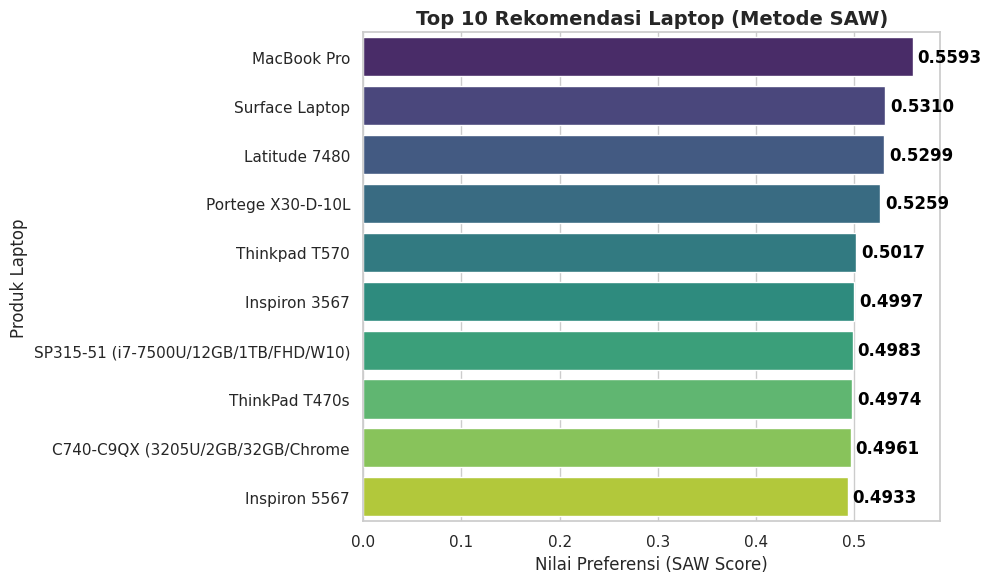

In [7]:
top_10 = ranked_df.head(10) # Data sudah terurut descending dari langkah sebelumnya

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='SAW_Score', y='Product', data=top_10, hue='Product', legend=False, palette='viridis')

plt.title('Top 10 Rekomendasi Laptop (Metode SAW)', fontsize=14, fontweight='bold')
plt.xlabel('Nilai Preferensi (SAW Score)', fontsize=12)
plt.ylabel('Produk Laptop', fontsize=12)
plt.xlim(0, top_10['SAW_Score'].max() * 1.05) # Sedikit padding di kanan

# Tambahkan label nilai di ujung bar
for i, v in enumerate(top_10['SAW_Score']):
    ax.text(v + 0.005, i, f'{v:.4f}', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()